In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.model_selection import train_test_split 
from sklearn import metrics, preprocessing, svm

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

In [4]:
df = pd.read_csv('data/train_data.csv')
df.set_index('date', inplace=True)
df

,merchant_name,cashback,category,id
date,,,,
2022-02-10,Megogo,681.27,Сервис,0
2022-02-11,Megogo,1171.52,Сервис,0
2022-02-12,Megogo,1068.24,Сервис,0
2022-02-13,Megogo,1023.07,Сервис,0
2022-02-14,Megogo,559.56,Сервис,0
...,...,...,...,...
2022-10-29,Телемедицина от МЕДСИ,195.97,NaN,2547
2022-10-30,Телемедицина от МЕДСИ,223.59,NaN,2547
2022-10-31,Телемедицина от МЕДСИ,153.72,NaN,2547


In [5]:
ids_list = list(set(df['id']))

In [6]:
datal = {}

for i in ids_list:
    count = len(df[df['id']==i])
    budget = int(df.loc[df['id'] == i, 'cashback'].sum())
    if (count > 60) and (budget > 5000):
        datal[i] = [count, budget, df.loc[df['id'] == i, 'merchant_name'].iloc[0]]
        

datal = dict(sorted(datal.items(), key=lambda item: item[1], reverse=True))

In [72]:
ndfx = pd.DataFrame({'id': pd.Series(dtype='int'),
                   'cashback': pd.Series(dtype='float'),
                   'date': pd.Series(dtype='datetime64[ns]')})
# ndfy = pd.DataFrame({'id': pd.Series(dtype='int'),
#                    'cashback': pd.Series(dtype='float'),
#                    'date': pd.Series(dtype='datetime64[ns]')})

Y = pd.DataFrame({'id': pd.Series(dtype='int'), 'spent_5days': pd.Series(dtype='float')})

idd = 0
batch_size = 20
pred_size = 5
for x in list(datal.items()):
    dx = df[df['id'] == x[0]]
    for i in range(0, len(dx)-2*batch_size, batch_size):
        idd+=1
        for j in range(i+batch_size):
            ndfx.loc[len(ndfx)] = [idd, dx[j:j+1]['cashback'].iloc[0], dx[j:j+1].index.min()]
        Y.loc[len(Y)] = [int(idd), dx[i+batch_size:i+batch_size+pred_size]['cashback'].sum()]
        # for j in range(5):
        #     ndfy.loc[len(ndfy)] = [idd, dx[i+5+j:i+5+j+1]['cashback'].iloc[0], dx[i+5+j:i+5+j+1].index.min()]
Y = Y.astype(int)

In [8]:
ndfx

,id,cashback,date
0,1,1789.93,2022-01-01
1,1,1471.19,2022-01-02
2,1,1201.66,2022-01-03
3,1,986.97,2022-01-04
4,1,981.66,2022-01-05
...,...,...,...
16535,243,236.90,2022-07-25
16536,243,289.70,2022-07-26
16537,243,367.19,2022-07-27
16538,243,385.22,2022-07-28


In [73]:
extraction_settings = ComprehensiveFCParameters()

X = extract_features(ndfx, column_id='id', column_sort='date', column_value='cashback',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)


Feature Extraction: 100%|█████████████████████████████████████████████████████| 19/19 [00:02<00:00,  7.06it/s]


In [74]:
Y.set_index('id', inplace=True)

In [32]:
X = select_features(X, Y['spent_5days'])

In [75]:
# cashback__kurtosis
# cashback__mean_second_derivative_central
# cashback__fft_aggregated__aggtype_"variance"
# cashback__agg_autocorrelation__f_agg_"var"__maxlag_40
# cashback__fft_aggregated__aggtype_"centroid"
# cashback__cid_ce__normalize_True
# cashback__cid_ce__normalize_False
# cashback__variation_coefficient
# cashback__skewness
X = X[['cashback__kurtosis',
   'cashback__mean_second_derivative_central',
   'cashback__fft_aggregated__aggtype_"variance"',
   'cashback__agg_autocorrelation__f_agg_"var"__maxlag_40',
   'cashback__fft_aggregated__aggtype_"centroid"',
   'cashback__cid_ce__normalize_True',
   'cashback__cid_ce__normalize_False',
   'cashback__variation_coefficient',
   'cashback__skewness'
]]

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

In [354]:
# X_test, y_test = X_test[:50], y_test[:50]

In [77]:
X_test

,cashback__kurtosis,cashback__mean_second_derivative_central,"cashback__fft_aggregated__aggtype_""variance""","cashback__agg_autocorrelation__f_agg_""var""__maxlag_40","cashback__fft_aggregated__aggtype_""centroid""",cashback__cid_ce__normalize_True,cashback__cid_ce__normalize_False,cashback__variation_coefficient,cashback__skewness
239,-0.733481,-0.272763,40.560457,0.054077,4.672335,7.353375,1316.307896,0.335671,0.365121
218,-0.044298,-215.235278,10.975304,0.061923,2.844771,6.281838,32034.494236,0.563398,0.851387
51,0.117843,-2.145787,643.525652,0.044376,16.307870,9.195772,4370.657893,0.248752,-0.522140
83,-0.513045,1.187885,106.296333,0.116872,5.803672,6.211282,9723.270286,0.260452,-0.255536
174,5.262263,0.641389,10.910221,0.039212,3.209745,5.637167,627.034863,0.887150,2.060857
...,...,...,...,...,...,...,...,...,...
210,0.213261,-1.731667,8.089021,0.241359,2.527874,5.529799,376.881736,0.630913,1.192983
42,1.819393,-0.112395,970.482443,0.192460,22.562406,4.368142,7671.071653,1.898182,1.801771
152,-1.647665,-1.544444,8.271423,0.407789,2.294244,2.555812,1264.357103,1.160136,0.562105
157,-0.675167,-16.095000,39.635041,0.114278,5.250832,8.484073,6684.787188,0.411985,0.415316


In [78]:
regr =  Lasso(alpha=0.2)
 
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.6015561008559387


In [79]:
regr.intercept_

array([60792.68467118])

In [146]:
with open('models/model_2.1(81).pkl', 'wb') as outp:
    pickle.dump(regr, outp, pickle.HIGHEST_PROTOCOL)

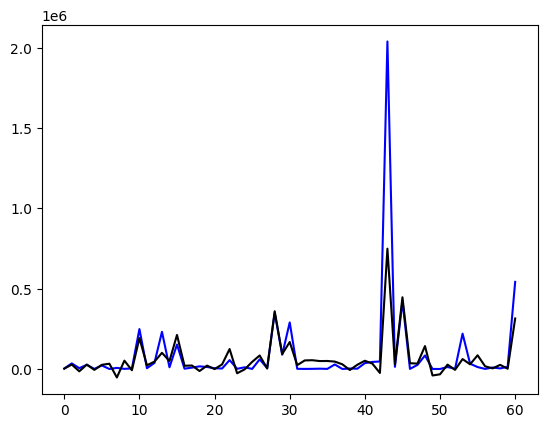

In [80]:
y_pred = regr.predict(X_test)
plt.plot(list(range(len(y_test))), y_test, color ='b')
plt.plot(list(range(len(y_pred))), y_pred, color ='k')
 
plt.show()

In [82]:
mae = metrics.mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = metrics.root_mean_squared_error(y_true=y_test,y_pred=y_pred)
tink_metr = (np.array(y_test) - 5*y_pred).mean()

print(mae)
print(mse)
print(tink_metr)

55190.85532233473
173221.3541575484
-236993.67318134685
